In [1]:
#where to load the dataset labels
test_path = 'data/images_scraped/'

In [2]:
#where to load the net to use
SAVE_PATH = 'trained/scheduler_resnet/new_res18_25_best.pth'

using_res = True

### Imports

In [3]:
import os

only_dirs = [ name for name in os.listdir(test_path) if 
                 os.path.isdir(os.path.join(test_path, name)) ]

diz = {}
nocl=0 #num of classes
for d in only_dirs:
    diz[nocl] = d
    nocl+=1
    
print(diz.values())

dict_values(['hyundai', 'lexus', 'mazda', 'mercedes', 'opel', 'skoda', 'toyota', 'volkswagen'])


In [4]:
#where the images are located and their class
test_path2 = 'images/mercedes-conv3/'
SINGLE_CLASS = 'mercedes'

LABEL_INDEX = list(diz.values()).index(SINGLE_CLASS)

In [5]:
import torch, torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage, CenterCrop, Normalize, Compose
from torchvision.transforms.functional import to_grayscale, to_tensor, rotate, hflip
import matplotlib.pyplot as plt

import random
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import seaborn as sn
import numpy as np

import io
from PIL import Image
from PIL.features import pilinfo

from copy import deepcopy


import traceback
import warnings
warnings.filterwarnings("error")

import cv2
from numpy import asarray
import copy

### Useful functions to retrive the data

In [6]:
# create a annotations_file.csv (index -> img (name), label (int))

def getLabelList(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # print(len(os.listdir(new_path)))
        for img in [ name for name in os.listdir(new_path) ]:
            ret[index] = [img, label]
            index += 1
    
    return pd.Series(ret)

In [7]:
# for the single class usage, i have only images in the test_path2 and i put manually the label to each
def getSingleLabelList(path):
    ret = {}
    index = 0
    for img in [ name for name in os.listdir(path) ]:
        ret[index] = [img, LABEL_INDEX]
        index += 1
    
    return pd.Series(ret)

In [8]:
# create the pool of images (with a series that contains all the images, more deeply: index -> abs path, label (int), class (string))

def getImgPool(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # cnt = 0
        for img in [ name for name in os.listdir(new_path) ]:
            abs_path = new_path + '/' + img
            ret[index] = [abs_path, label, d]
            index += 1
            # cnt += 1
        # print(f"Label: {d} - Number: {cnt}")
    
    return pd.Series(ret)

In [9]:
# create the pool of images from video (with a series that contains all the images, more deeply: index -> abs path, label (int), class (string))

def getSingleImgPool(path):
    ret = {}
    index = 0
    for img in [ name for name in os.listdir(path) ]:
        abs_path = path + '/' + img
        ret[index] = [abs_path, LABEL_INDEX, SINGLE_CLASS]
        index += 1
    
    return pd.Series(ret)

### Defining the custom dataset (structure that holds the data)

#### old version

In [10]:
if not using_res:
    # wrong_images_path = []
    # import traceback

    class CustomImageDataset(Dataset):
        def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True, single_class=None):
            if single_class is not None:
                self.img_labels = getSingleLabelList(path_labels)
                self.images = getSingleImgPool(path_labels)
            else:
                self.img_labels = getLabelList(path_labels)
                self.images = getImgPool(path_labels)
            self.transform = transform
            self.target_transform = target_transform
            self.use_aug = use_aug

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            try: 
                image = read_image(self.images.loc[idx][0])
            except Exception:
                print('Found error at {} {}'.format(self.images.loc[idx][0], idx))
            #     wrong_images_path.append(self.images.loc[img_name][0])
                #return torch.zeros((1, 600, 600)), -1
            # image = read_image(self.images.loc[img_name][0])
            if image.shape[0] >= 3: #apply grayscale to colored img
                image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=1))
            else: #we have a greyscaled image, move it into tensor 
                image = to_tensor(ToPILImage()(image))

            image = Resize((300, 300))(image)
            #data augmentation
            if self.use_aug:
                fr = random.choices([0,1],[0.2,0.8])[0]
                if fr == 1: 
                    angle = torch.randint(40, size=(1,)).item() - 20
                    #print (f'Rotate: {angle}')
                    image = rotate(image, angle)

                fr = random.choices([0,1],[0.5,0.5])[0]
                if fr == 1: 
                    image = hflip(image)

            #image = image.permute(1,2,0) #made to be shown on matplotlib
            label = self.img_labels.loc[idx][1]
            #if self.transform:
            #    image = self.transform(image)
            #if self.target_transform:
            #    label = self.target_transform(label)

            return image, label

#### new version (resnet)

In [11]:
if using_res:
    wrong_images_path = []

    class CustomImageDataset(Dataset):
        def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True, single_class=None):
            if single_class is not None:
                self.img_labels = getSingleLabelList(path_labels)
                self.images = getSingleImgPool(path_labels)
            else:
                self.img_labels = getLabelList(path_labels)
                self.images = getImgPool(path_labels)
            self.transform = transform
            self.target_transform = target_transform
            self.use_aug = use_aug

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            try: 
                image = Image.open(self.images.loc[idx][0])
                # exif_data = image._getexif()
                if Image.MIME[image.format] == 'image/png': #wrong format, we want only jpg
                        image = convertPNGImage(self.images.loc[idx][0], 'PNG')
            # except UserWarning:
            #     print('Found exif error at {} in position {}'.format(self.images.loc[idx][0], idx))
            #     wrong_images_path.append('EXIF '+self.images.loc[idx][0])
            except Exception:
                print('Found exif error at {} in position {}'.format(self.images.loc[idx][0], idx))
                # wrong_images_path.append(self.images.loc[idx][0])
                
            image = ToTensor()(image)
            
            if image.shape[0] != 3: #color grayscaled and convert RGBA
                image = ToPILImage()(image).convert('RGB')
                
            else: #rgb, don't touch it 
                image = ToPILImage()(image)
                
            preprocess = Compose([
                # Resize(300),
                # CenterCrop(300),
                Resize(450),
                CenterCrop(300),
                
                
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            image = preprocess(image)
            
            
            #  COMMENT ME
            # print(f"idx: {idx} - path: {self.images.loc[idx][0]}")
            
            
            
            #data augmentation
            if self.use_aug:
                fr = random.choices([0,1],[0.2,0.8])[0]
                if fr == 1: 
                    angle = torch.randint(40, size=(1,)).item() - 20
                    #print (f'Rotate: {angle}')
                    image = rotate(image, angle)

                fr = random.choices([0,1],[0.5,0.5])[0]
                if fr == 1: 
                    image = hflip(image)

            label = self.img_labels.loc[idx][1]

            return image, label

### Creating the 2 dataset and testing

In [12]:
# train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), num_of_channels=3)
# test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), num_of_channels=3)

test_data = CustomImageDataset(path_labels=test_path2, transform=ToTensor(), 
                               target_transform=ToTensor(), use_aug=False, single_class=SINGLE_CLASS)

print (f'test dataset: {test_data.__len__()}')

test dataset: 286


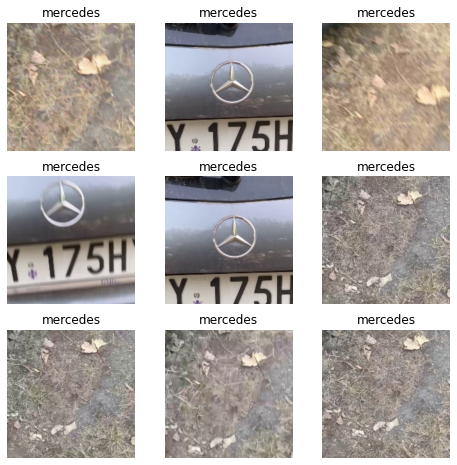

In [13]:
#testing dataset if images are loaded

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item() 
    img, label = test_data[sample_idx]
    if using_res:
        img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    # print (img.shape, img.dtype, label)
    figure.add_subplot(rows, cols, i)
    plt.title(diz[label])
    plt.axis("off")
    if not using_res:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(img.permute(1,2,0)) #use this if rbg
plt.show()

### creating dataloader (who iterate on data, create batches and shuffles it)


Feature batch shape: torch.Size([24, 3, 300, 300])
Labels batch shape: torch.Size([24])


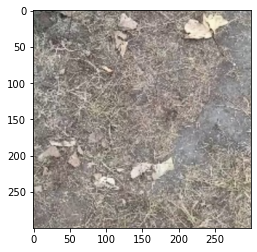

Label: mercedes


In [14]:
test_dl = DataLoader(test_data, batch_size=24, shuffle=False)

#dataloader test (ask a batch or a sample)
images, labels = next(iter(test_dl)) #picking a batch
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
img = images[0] #picking the first img and label of the batch

if using_res:
    img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
label = labels[0]
if not using_res:
    plt.imshow(img.squeeze(), cmap='gray')
else:
    plt.imshow(img.permute(1,2,0)) #use this if rbg
plt.show()
print(f"Label: {diz[label.item()]}")

In [15]:
labels

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

### Defining the neural network

In [16]:
print("GPU compute available: ", torch.cuda.is_available())


GPU compute available:  True


In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [18]:
if not using_res:
    class Net(nn.Module):

        def __init__(self):
            super(Net, self).__init__()

            #conv1: 1 input image channel (image channel, 1 gray, 3 rgb), 6 output channels (depth [K]), 5x5 square convolution kernel, DEFAULT: stride = 1,1, padding = 0
            self.conv1 = nn.Conv2d(1, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)        
            self.fc_layer1 = nn.Linear(16 * 72 * 72, 120)        
            self.fc_layer2 = nn.Linear(120, 84)
            self.fc_layer3 = nn.Linear(84, nocl) # nocl is the num of classes

        def forward(self, x):
            # Max pooling over a (2, 2) window
            x = self.pool(F.relu(self.conv1(x)))
            #print ('conv1', x.shape)
            # If the size is a square, you can specify with a single number
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
            #print ('flatten', x.shape)
            x = F.relu(self.fc_layer1(x))
            x = F.relu(self.fc_layer2(x))
            x = self.fc_layer3(x)
            return x

### Testing the network on test set

In [19]:
if not using_res:
    loaded = Net()
else:
    loaded = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Using cache found in C:\Users\eliad/.cache\torch\hub\pytorch_vision_v0.10.0


In [20]:
loaded.load_state_dict(torch.load(SAVE_PATH))
loaded.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

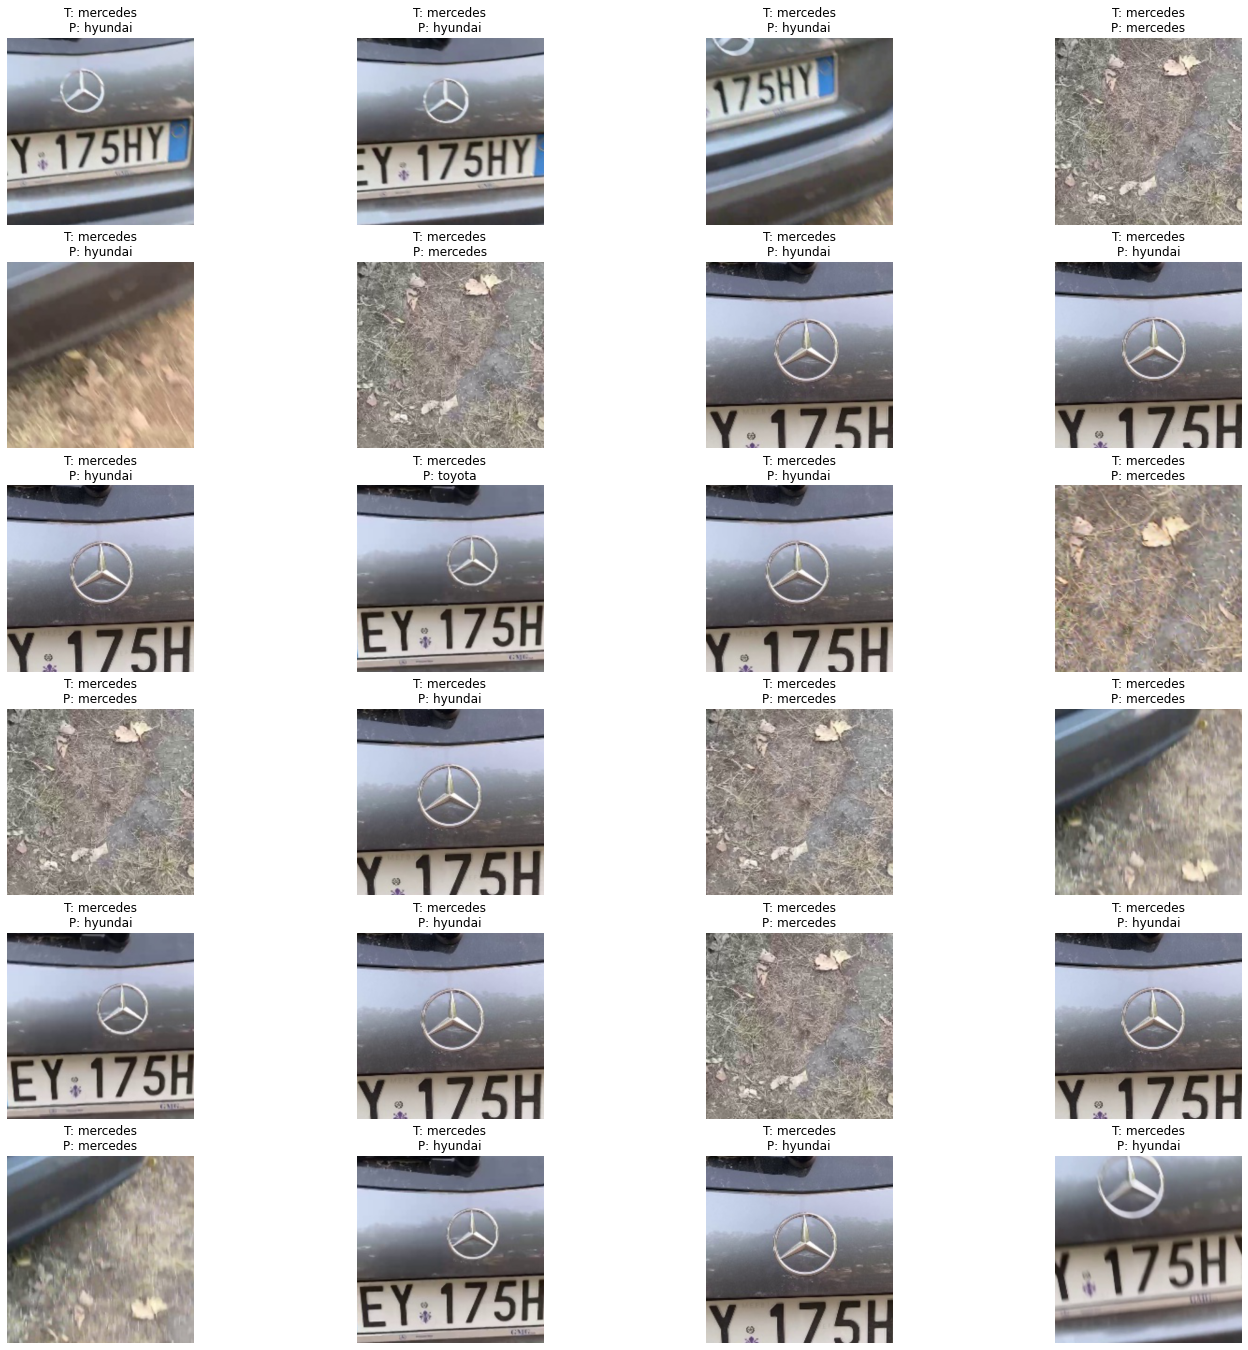

In [21]:
shuffle_dl = DataLoader(test_data, batch_size=24, shuffle=True)
images, labels = next(iter(shuffle_dl)) #picking a batch

n_imgs = len(images)

preds = loaded(images)
_, best_pred = torch.max(preds.data, 1)

figure = plt.figure(figsize=(24, 24))
cols, rows = 4, int(n_imgs/4)
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.title('T: {}\nP: {}'.format(diz[labels[i-1].item()], diz[best_pred[i-1].item()]))
    plt.axis("off")
    if not using_res:
        plt.imshow(images[i-1].squeeze(), cmap='gray')
    else:
        images[i-1] = images[i-1] * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
        plt.imshow(images[i-1].permute(1,2,0)) #use this if rbg
plt.show()

# axs[i].set_title('T: {}\nP: {}'.format(diz[label[i].item()], diz[best_pred[i].item()]))

In [22]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in diz}
total_pred = {classname: 0 for classname in diz}

y_true = []
y_pred = []

# again no gradients needed
# with torch.no_grad():
for data in test_dl:
    images, labels = data
    outputs = loaded(images)
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[label.item()] += 1
        else:
            correct_pred[prediction.item()] += 1 
        total_pred[label.item()] += 1
        y_true.append(label.cpu())
        y_pred.append(prediction.cpu())

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] == 0: #wrong class pred
        accuracy = 100 * float(correct_count) / test_data.__len__()
    else:
        accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Predictions for class: {diz[classname]} is {accuracy:.1f} %')

Predictions for class: hyundai is 58.7 %
Predictions for class: lexus is 2.1 %
Predictions for class: mazda is 0.0 %
Predictions for class: mercedes is 33.6 %
Predictions for class: opel is 1.0 %
Predictions for class: skoda is 0.0 %
Predictions for class: toyota is 0.3 %
Predictions for class: volkswagen is 4.2 %


In [23]:
# sample_idx = torch.randint(len(test_data), size=(1,)).item() 
# img, label = test_data[sample_idx]

# print(f"pre norm: min value {img.min()} - max value {imgs.max()}")
# plt.imshow(img.permute(1,2,0))
# plt.title("pre norm img")
# plt.show()
# img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
# print(f"after norm: min value {img.min()} - max value {imgs.max()}")
# plt.imshow(img.permute(1,2,0))
# plt.title("after norm img")
# plt.show()
# img = img.permute(1,2,0)
# img = img.numpy()
# img = (img*255).astype(np.uint8)

# print(f"after conv: min value {img.min()} - max value {img.max()}")
# plt.imshow(img)
# plt.title("after conv img")
# plt.show()

# # plt.hist(img.ravel(), bins=50, density=True)
# # plt.show()

# fig, axs = plt.subplots(figsize=(16,4), nrows=1, ncols=2)

# axs[0].imshow(img)
# axs[0].set_title('video')

# #creating barplot
# plt.ylim(0, 100)
# values = torch.rand(8) * 100
# plt.bar(diz.values(), values, width=0.5)
# axs[1].set_title('random predictions')

# buf = io.BytesIO()
# fig.savefig(buf, format='jpeg')
# buf.seek(0)
# # frame = np.reshape(np.frombuffer(buf.getvalue(), dtype=np.uint8), 
# #                    newshape=(int(fig.bbox.bounds[2]), int(fig.bbox.bounds[3]), -1))
# frame = Image.open(buf)
# plt.close(fig)

# frame = asarray(frame)

# plt.figure(figsize=(15, 15), dpi=125)
# plt.imshow(frame)
# plt.title("after buffer img")
# plt.show()

image processed: 20/286


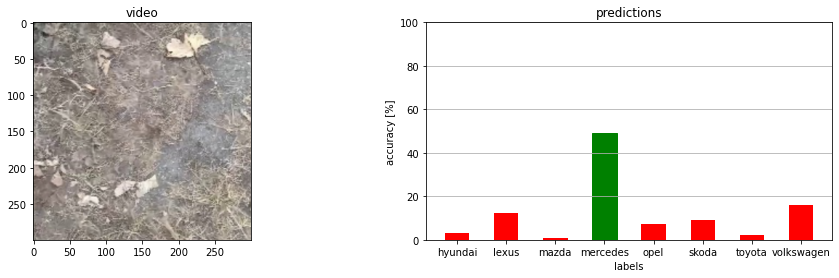

image processed: 40/286


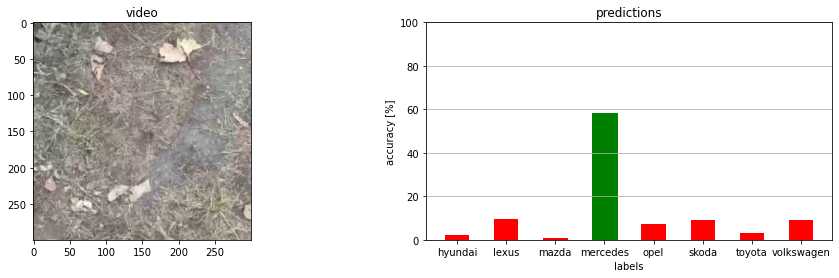

image processed: 60/286


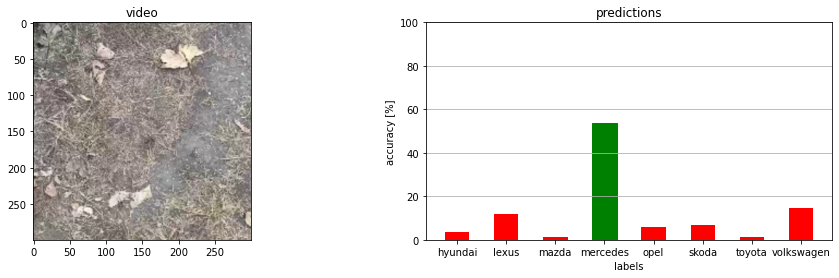

image processed: 80/286


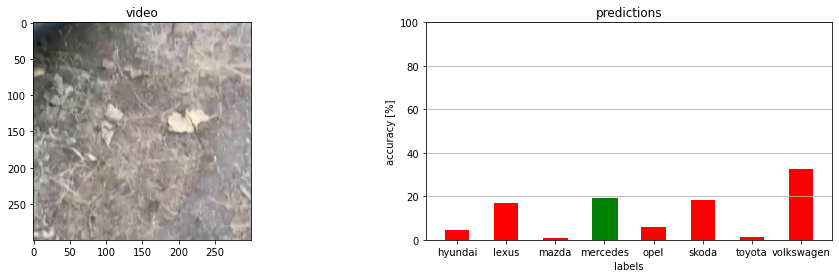

image processed: 100/286


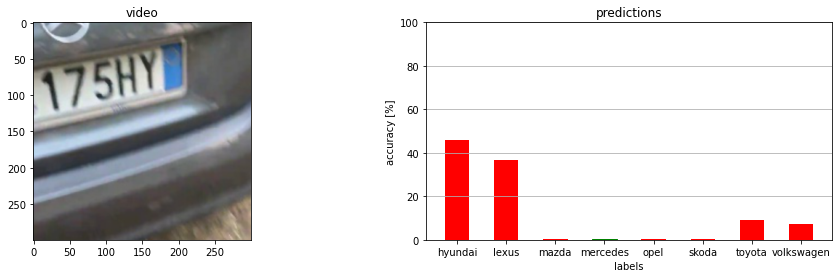

image processed: 120/286


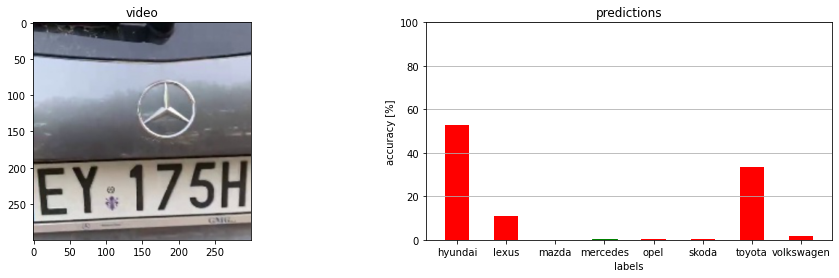

image processed: 140/286


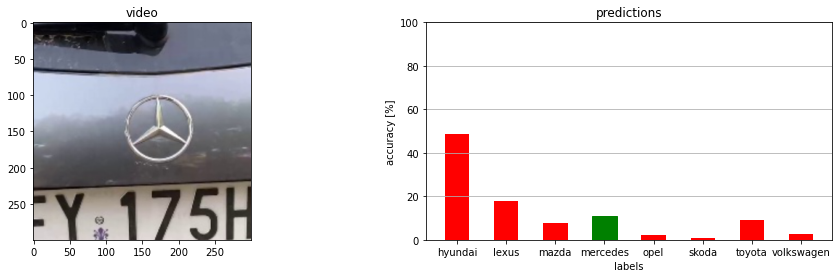

image processed: 160/286


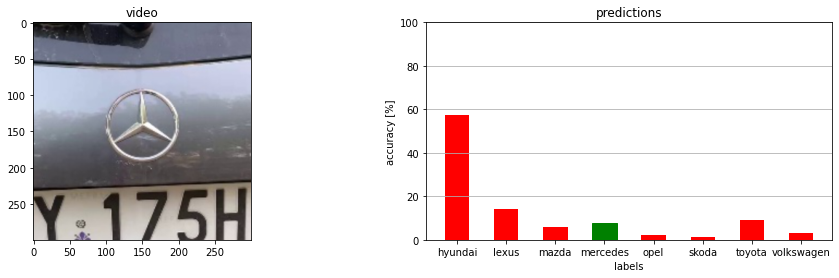

image processed: 180/286


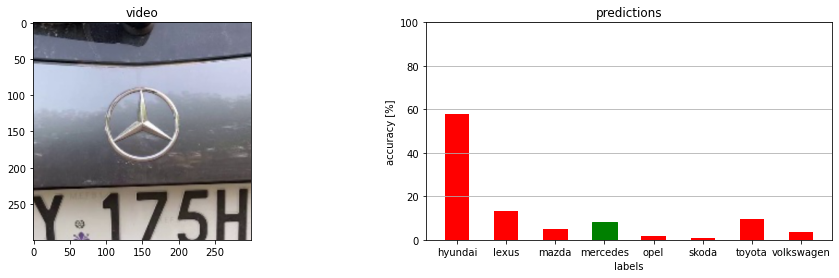

image processed: 200/286


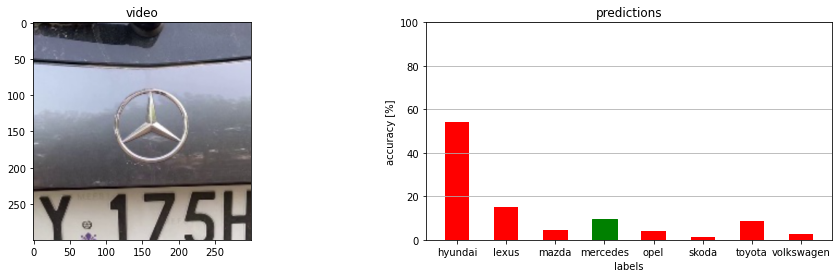

image processed: 220/286


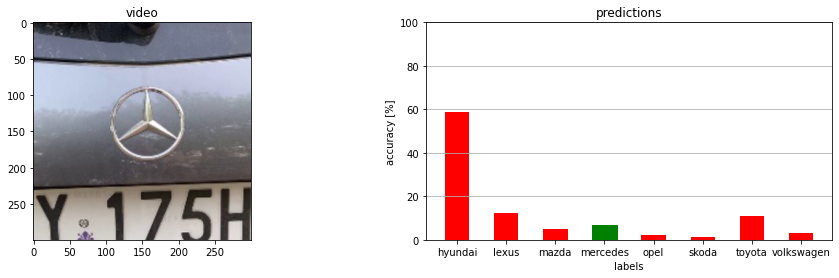

image processed: 240/286


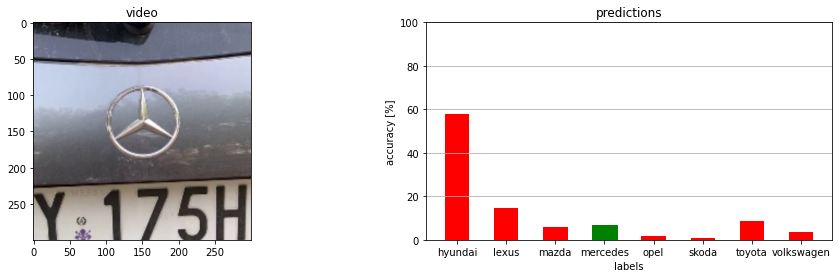

image processed: 260/286


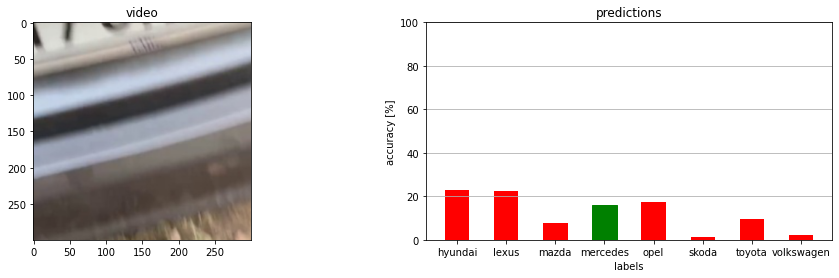

image processed: 280/286


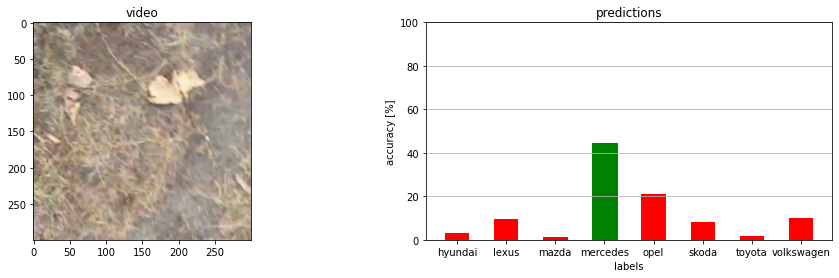

finished writing at: video/mercedes-conv3_scheduler_resnet_zoom.mp4


In [24]:
fig, axs = plt.subplots(figsize=(16,4), nrows=1, ncols=2)
size = fig.get_size_inches()*fig.dpi # size in pixels
plt.close(fig)

### choose codec according to format needed
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
VIDEO_PATH = 'video/' + test_path2.split('/')[1] + '_' + SAVE_PATH.split('/')[1] + '_zoom.mp4'
video = cv2.VideoWriter(VIDEO_PATH, fourcc, 30, (int(size[0]),int(size[1])), isColor=True)

test_dl_single = DataLoader(test_data, batch_size=1, shuffle=False)
diz2 = copy.deepcopy(diz)


i = 0
for batch in test_dl_single:
    imgs, label = batch
    out = loaded(imgs)
    _, best_pred = torch.max(out.data, 1)
    perc = torch.nn.functional.softmax(out, dim=1)[0] * 100    
    _, indices = torch.sort(out, descending=True)
    # print(f"{[(diz[idx.item()], perc[idx].item()) for idx in indices[0][:8]]}")
    for img in imgs:
        img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
        img = img.permute(1,2,0)
        img = img.numpy()
        img = (img*255).astype(np.uint8)
        
        fig, axs = plt.subplots(figsize=(16,4), nrows=1, ncols=2)

        axs[0].imshow(img)
        axs[0].set_title('video')

        #creating barplot
        plt.ylim(0, 100)
        for idx in indices[0][:8]:
            diz2[idx.item()] = perc[idx].item()
        
        bars = plt.bar(diz.values(), diz2.values(), width=0.5, color='red')
        for idx, bar in enumerate(bars):
            if list(diz.keys())[idx] == LABEL_INDEX:
                bar.set_color("green")
        axs[1].set_title('predictions')
        axs[1].set_xlabel('labels')
        axs[1].set_ylabel('accuracy [%]')
        axs[1].grid(axis='y')

        buf = io.BytesIO()
        fig.savefig(buf, format='jpeg')
        buf.seek(0)
        frame = Image.open(buf)
        
        frame = asarray(frame)
        
        # print(frame.shape)
        video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        if i % 20 == 0 and i != 0:
            print(f"image processed: {i}/{test_data.__len__()}")
            plt.show()
        i +=1
        plt.close(fig)

        
# print(i)
cv2.destroyAllWindows()
video.release()
print('finished writing at: {}'.format(VIDEO_PATH))